In [31]:
import cv2
import numpy as np
import os
from skimage.util import img_as_float
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.path as mplPath
import util
from timeit import default_timer as timer
from datetime import datetime
from skimage.segmentation import mark_boundaries

In [44]:
folderPageImages = 'parzivalDataset'; 
folderGroundThruth = 'groundTruth'
folderUnetData = 'unetParzivalData'
y_train = []
y_test = []
y_validation = []

segments_train = []
segments_test = []
segments_validation = []
factor = 1

#### Leyendo las imágenes de los documentos y sus respectivos archivos XML que contienen los segmentos (ground truth) como coordenadas de polígonos


In [45]:
import importlib
importlib.reload(util)
startTime = datetime.now()   
ximg_train,      xgt_train, xnames_train      = util.unetReadPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'train', factor)     
ximg_test,       xgt_test, xnames_test       = util.unetReadPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'test', factor)
ximg_validation, xgt_validation, xnames_validation = util.unetReadPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'validation', factor)
print("Time taken:", datetime.now() - startTime)

Time taken: 0:00:50.666710


In [46]:
#['peripheric','page', 'text', 'decoration', 'comment']
image = ximg_train[7]
gt = xgt_train[7]
imageCopy = image.copy()
imageCopy[:,:] = (0,0,0)
imageLabel = np.ndarray(shape=(image.shape[0],image.shape[1],5), dtype=float)
imageLabel[:,:] = (1,0,0,0,0)

In [47]:
np.shape(imageLabel)

(3008, 2000, 5)

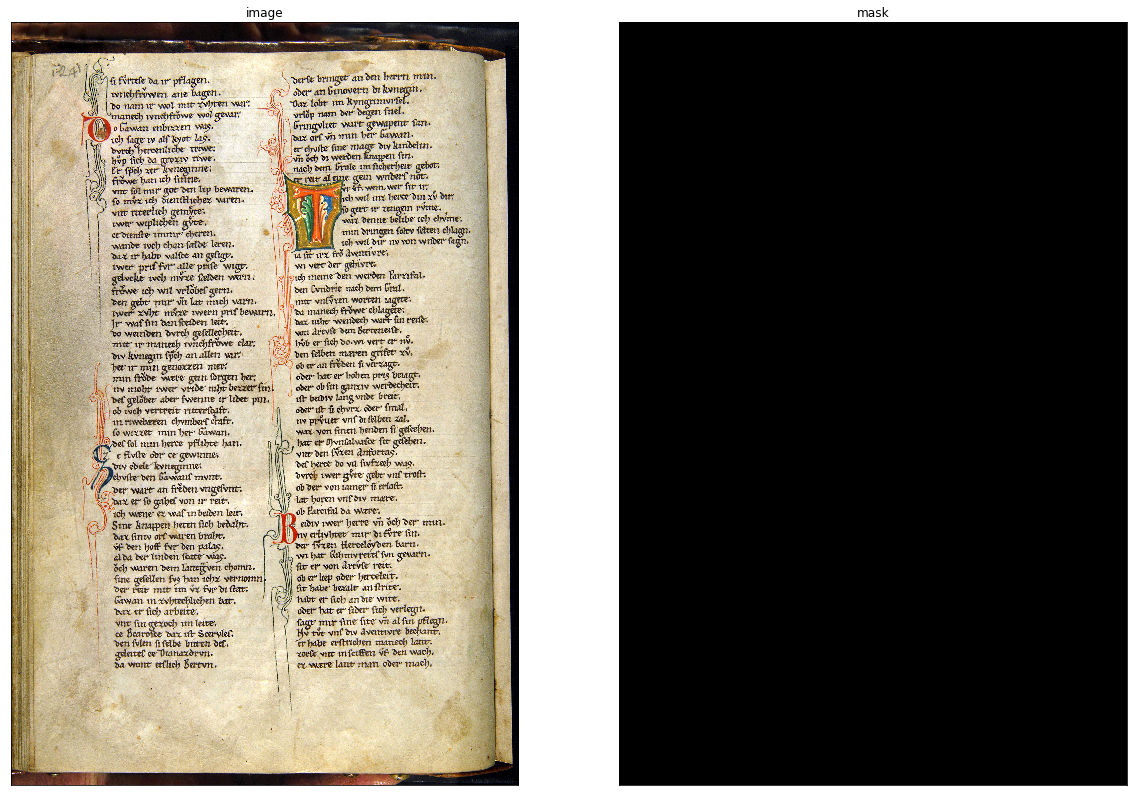

In [48]:
util.subplot(titles=["image","mask"],images=[image,imageCopy], rows=1, imgPerRows=2, size=20)

In [49]:
# imageWidth = imageCopy.shape[1] #Get image width
# imageHeight = imageCopy.shape[0] #Get image height
# #regions = ['text','decoration','comment', 'page']
# regions = ['page', 'text', 'decoration', 'comment']

# for k in range(len(regions)) :
#     listPolygons = util.groundThruthFindCountourPointsByRegion(folderGroundThruth + "/" + "train" + "/" + gt, regions[k])
#     print("len poligonos: " + str(len(listPolygons)))
#     for polygon in listPolygons :
#         xPos, yPos = 0, 0
#         while xPos < imageWidth: #Loop through rows
#             while yPos < imageHeight: #Loop through collumns
#                 if util.isInsidePolygon (polygon, xPos*2**3, yPos*2**3) :
#                     if regions[k] == 'page' :
#                         imageCopy.itemset((yPos, xPos, 0), 1)
#                         imageCopy.itemset((yPos, xPos, 1), 1)
#                         imageCopy.itemset((yPos, xPos, 2), 1)  
#                         imageLabel[yPos, xPos] = (0,1,0,0,0)
#                     elif regions[k] == 'text' : 
#                         imageCopy.itemset((yPos, xPos, 0), 0)
#                         imageCopy.itemset((yPos, xPos, 1), 0)
#                         imageCopy.itemset((yPos, xPos, 2), 1) 
#                         imageLabel[yPos, xPos] = (0,0,1,0,0)
#                     elif regions[k] == 'decoration' : 
#                         imageCopy.itemset((yPos, xPos, 0), 1)
#                         imageCopy.itemset((yPos, xPos, 1), 0)
#                         imageCopy.itemset((yPos, xPos, 2), 0)
#                         imageLabel[yPos, xPos] = (0,0,0,1,0)
#                     elif regions[k] == 'comment' : 
#                         imageCopy.itemset((yPos, xPos, 0), 0)
#                         imageCopy.itemset((yPos, xPos, 1), 1)
#                         imageCopy.itemset((yPos, xPos, 2), 0) 
#                         imageLabel[yPos, xPos] = (0,0,0,0,1)
#                 yPos = yPos + 1
#             yPos = 0
#             xPos = xPos + 1 #Increment X position by 1

len poligonos: 1
len poligonos: 2
len poligonos: 4
len poligonos: 0


In [49]:
def makeUnetLabels (arrImg, arrGT, folder, factor) :
    regions = ['page', 'text', 'decoration', 'comment']
    arrImgSegments = []
    arrLabels = []
    for i in range(len(arrImg)) :
        print(folder)
        print("image: " + str(i))
        image = arrImg[i]
        imageCopy = image.copy()
        imageCopy[:,:] = (0,0,0)
        imageWidth = imageCopy.shape[1] #Get image width
        imageHeight = imageCopy.shape[0] #Get image height
        imageLabel = np.ndarray(shape=(image.shape[0],image.shape[1],5), dtype=float)
        imageLabel[:,:] = (1,0,0,0,0)        
        for k in range(len(regions)) :
            print("region: "+regions[k])
            listPolygons = util.groundThruthFindCountourPointsByRegion(folderGroundThruth + "/" + folder + "/" + arrGT[i], 
                                                                       regions[k])
            print("len poligonos: " + str(len(listPolygons)))
            for polygon in listPolygons :
                xPos, yPos = 0, 0
                while xPos < imageWidth: #Loop through rows
                    while yPos < imageHeight: #Loop through collumns
                        if util.isInsidePolygon (polygon, xPos*factor, yPos*factor) :
                            if regions[k] == 'page' :
                                imageCopy.itemset((yPos, xPos, 0), 1)
                                imageCopy.itemset((yPos, xPos, 1), 1)
                                imageCopy.itemset((yPos, xPos, 2), 1)  
                                imageLabel[yPos, xPos] = (0,1,0,0,0)
                            elif regions[k] == 'text' : 
                                imageCopy.itemset((yPos, xPos, 0), 0)
                                imageCopy.itemset((yPos, xPos, 1), 0)
                                imageCopy.itemset((yPos, xPos, 2), 1) 
                                imageLabel[yPos, xPos] = (0,0,1,0,0)
                            elif regions[k] == 'decoration' : 
                                imageCopy.itemset((yPos, xPos, 0), 1)
                                imageCopy.itemset((yPos, xPos, 1), 0)
                                imageCopy.itemset((yPos, xPos, 2), 0)
                                imageLabel[yPos, xPos] = (0,0,0,1,0)
                            elif regions[k] == 'comment' : 
                                imageCopy.itemset((yPos, xPos, 0), 0)
                                imageCopy.itemset((yPos, xPos, 1), 1)
                                imageCopy.itemset((yPos, xPos, 2), 0) 
                                imageLabel[yPos, xPos] = (0,0,0,0,1)
                        yPos = yPos + 1
                    yPos = 0
                    xPos = xPos + 1 #Increment X position by 1   
        arrImgSegments.append(imageCopy)
        arrLabels.append(imageLabel)
    return arrImgSegments, arrLabels

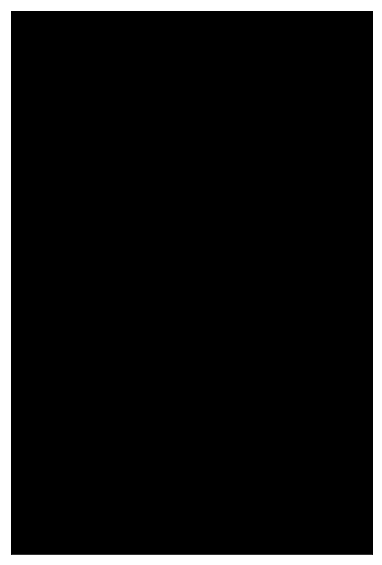

(3008, 2000, 5)
[ 1.  0.  0.  0.  0.]


In [50]:
util.plotImage(img=imageCopy, size=10)
print(np.shape(imageLabel))
print(imageLabel[200][200])

In [53]:
startTime = datetime.now()   
segments_train, y_train = makeUnetLabels(ximg_train, xgt_train, 'train', factor**-1)
segments_test, y_test = makeUnetLabels(ximg_test, xgt_test, 'test', 1)
segments_validation, y_validation = makeUnetLabels(ximg_validation, xgt_validation, 'validation', 1)
print("Time taken:", datetime.now() - startTime)

train
image: 0
region: page
len poligonos: 1
region: text
len poligonos: 2
region: decoration
len poligonos: 3
region: comment
len poligonos: 2
train
image: 1
region: page
len poligonos: 1
region: text
len poligonos: 2
region: decoration
len poligonos: 5
region: comment
len poligonos: 1
train
image: 2
region: page
len poligonos: 1
region: text
len poligonos: 2
region: decoration
len poligonos: 3
region: comment
len poligonos: 0
train
image: 3
region: page
len poligonos: 1
region: text
len poligonos: 2
region: decoration
len poligonos: 2
region: comment
len poligonos: 0
train
image: 4
region: page
len poligonos: 1
region: text
len poligonos: 2
region: decoration
len poligonos: 4
region: comment
len poligonos: 1
train
image: 5
region: page
len poligonos: 1
region: text
len poligonos: 2
region: decoration
len poligonos: 4
region: comment
len poligonos: 0
train
image: 6
region: page
len poligonos: 1
region: text
len poligonos: 2
region: decoration
len poligonos: 4
region: comment
len polig

FileNotFoundError: [Errno 2] No such file or directory: 'groundTruth/train/d-143_mathias.seuret@unifr.ch.xml'

In [10]:
from random import randint
randomTrain      = randint(0, len(y_train))
randomTest       = randint(0, len(y_test))
randomValidation = randint(0, len(y_validation))

print(randomTrain)
print(randomTest)
print(randomValidation)

len(y_test)

4
11
1


13

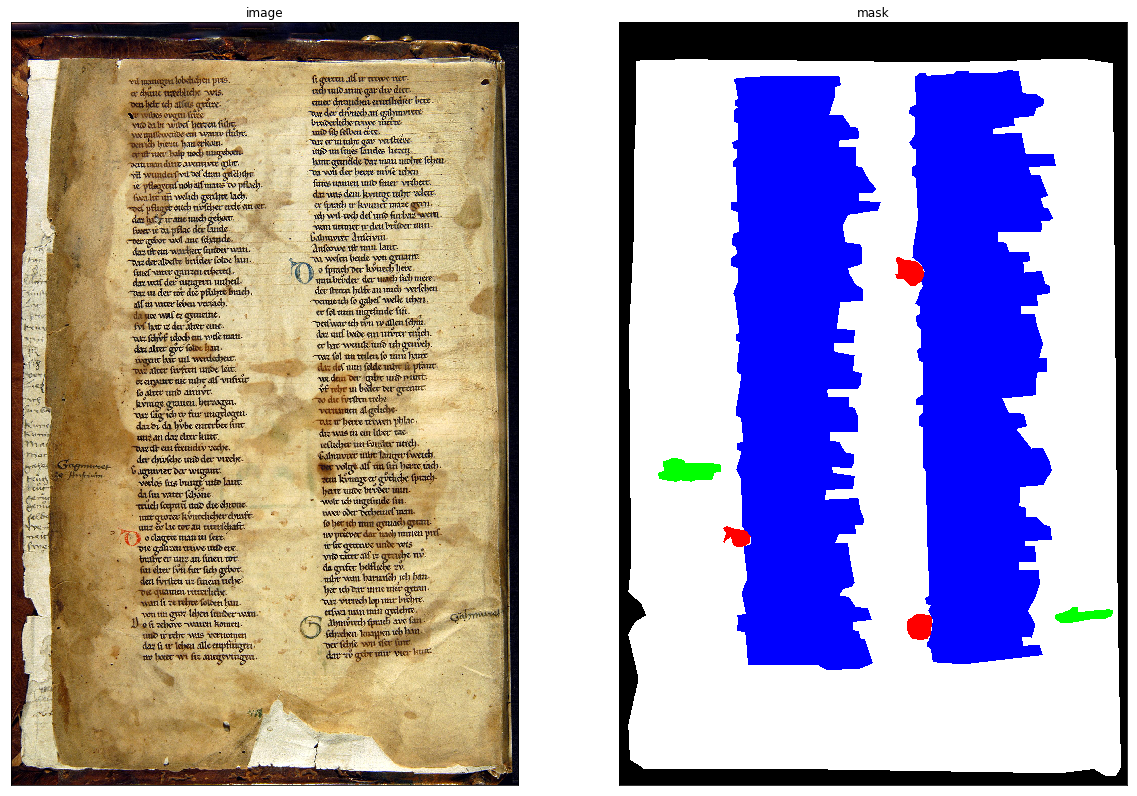

In [52]:
randomTrain      = randint(0, len(y_train)-1)
util.subplot(titles=["image","mask"],images=[ximg_train[randomTrain], segments_train[randomTrain]], rows=1, imgPerRows=2, size=20)

9


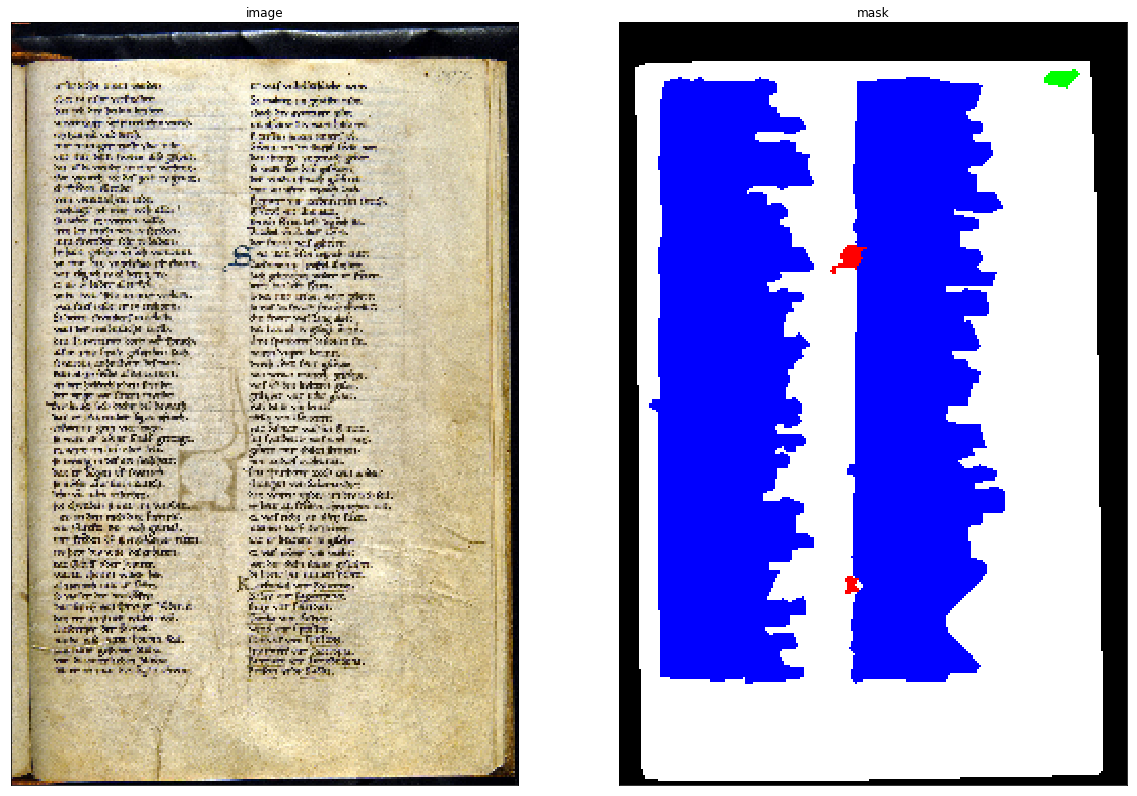

In [12]:
randomTest       = randint(0, len(y_test)-1)
print(randomTest)
util.subplot(titles=["image","mask"],images=[ximg_test[randomTest], segments_test[randomTest]], rows=1, imgPerRows=2, size=20)

0


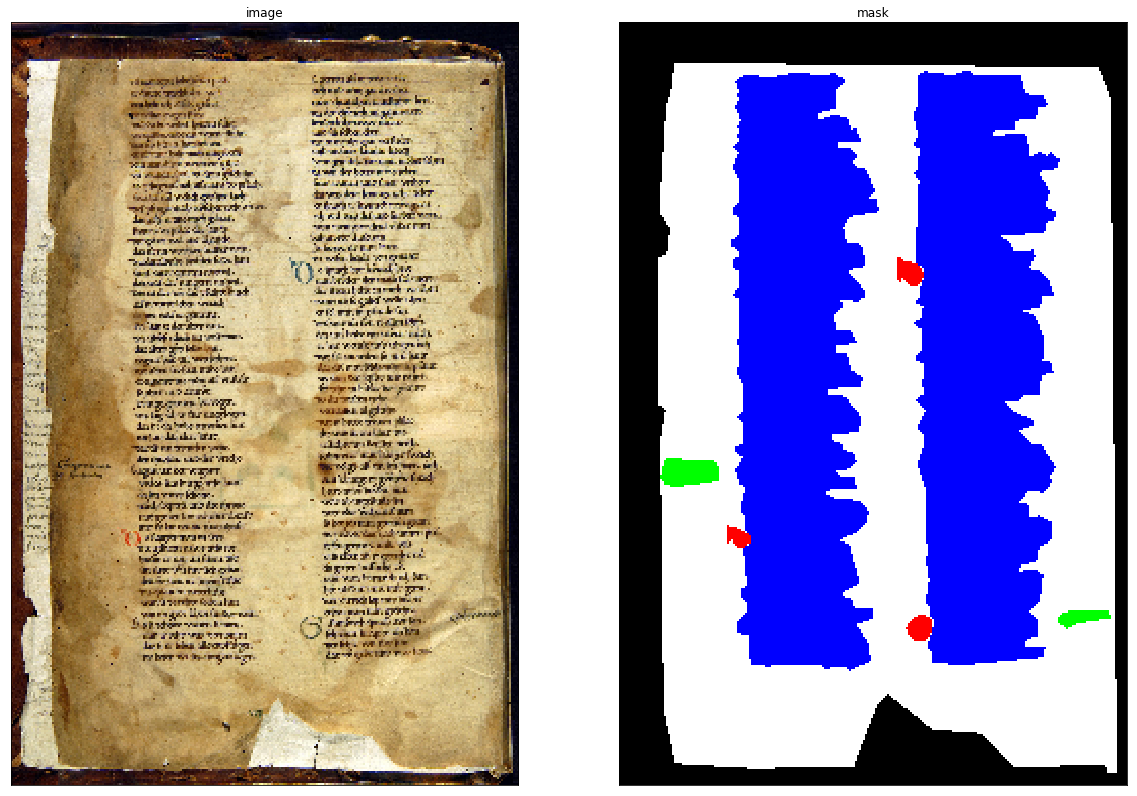

In [13]:
randomValidation = randint(0, len(y_validation)-1)
print(randomValidation)
util.subplot(titles=["image","mask"],images=[ximg_validation[randomValidation], segments_validation[randomValidation]], rows=1, imgPerRows=2, size=20)

### Saving unet parzival labels

In [141]:


# now you can call it directly with basename
print(os.path.splitext("eee.txt")[0])


eee


In [14]:
def saveUnetNumpyLabels (y, folder) :
    pathToSave = folderUnetData + "/" + folder + "/label"
    for t in range(len(y)) :
        nparray = y[t]
        if folder == "train" :
            np.save(pathToSave + "/"+ os.path.splitext(xnames_train[t])[0], nparray)
        elif folder == "test" :
            np.save(pathToSave + "/"+ os.path.splitext(xnames_test[t])[0], nparray)
        elif folder == "validation" :
            np.save(pathToSave + "/"+ os.path.splitext(xnames_validation[t])[0], nparray)
        

In [15]:
saveUnetNumpyLabels(y_train , "train")
saveUnetNumpyLabels(y_test ,  "test")
saveUnetNumpyLabels(y_validation , "validation")